In [1]:
# Mount your google drive. This will launch a pop-up window for authentication.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Adjust this to your directory

# Vincent
%cd "/content/drive/My Drive/es-143-assignments/Project/"

/content/drive/.shortcut-targets-by-id/17mZyNLFyCTqh7LTZoTP7xYmVLe94fbI9/Project


In [3]:
%pip install pupil-apriltags

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.4 MB/s eta 0:00:00


In [4]:
# Import any required libraries here
import cv2                   # OpenCV
import numpy as np                       # numpy
import scipy.interpolate  # interpolation
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
import plotly.graph_objects as go
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [5]:
#@title helper functions: `in2hom()`, `hom2in()`, `normalizing_transform()`

def in2hom(X):
    """
    Convert from inhomogeneous to homogeneous coordinates

    Args:
      X  - NxD numpy array, tyically with D=2 (rows (x,y)) or D=3 (rows (x,y,z))

    Returns:
      Xh - Nx(D+1) numpy array with an appended column of ones
    """

    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from homogeneous to inhomogeneous coordinates
def hom2in(X):
    """
    Convert from homogeneous to inhomogeneous coordinates

    Args:
      Xh  - Nx(D+1) numpy array, tyically with D=2 (rows (x,y,w)) or D=3 (rows (x,y,z,w))

    Returns:
      X - NxD numpy array with the first D columns divided by column (D+1)
    """

    return X[:, :-1] / X[:, -1:]

def normalizing_transform(X):
    """
    Compute a (Dx1)x(Dx1) normalizing transformation from N points in D dimensions

    Args:
      X - NxD numpy array, tyically with D=2 (rows (x,y)) or D=3 (rows (x,y,z))

    Returns:
      T - a (D+1)x(D+1) matrix that normalizes the points to be centered at their
          centroid, with average distance equal to sqrt(D)
    """

    # dimension of datapoints
    D = X.shape[1]

    # Compute centroid
    centroid = X.mean(axis=0, keepdims=True)

    # Compute the denominator of scale factor s
    denom = np.mean(np.sqrt(np.sum((X - centroid) ** 2, axis=1)))

    # Compute s, tx, ty
    s = np.sqrt(D) / denom
    t = -s * centroid[0, :]
    t = np.concatenate((t,np.array([1])))

    # return matrix T
    return np.concatenate((s*np.eye(D+1,D+1)[:,0:D], np.expand_dims(t,1)),axis=1)


#Calibrate Camera

In [6]:
response = requests.get("https://github.com/Harvard-CS283/pset-data/raw/f1a90573ae88cd530a3df3cd0cea71aa2363b1b3/april/AprilBoards.pickle")
data = pickle.loads(response.content)

at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

In [7]:
#@title Helper function: `detect_aprilboard()`
# set up april tag detector (I use default parameters; seems to be OK)
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

def detect_aprilboard(img, board, apriltag_detector):
    """
    Detects April tags in a grayscale image.

    Usage: imgpoints, objpoints, tag_ids = detect_aprilboard(img, board, AT_detector)

    Input:
        image -- grayscale image
        board -- at_coarseboard or at_fineboard (list of dictionaries)
        AT_detector -- AprilTag Detector parameters

    Returns:
        imgpoints -- Nx2 numpy array of (x,y) image coords
        objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
        tag_ids -- Nx1 list of tag IDs
    """

    imgpoints=[]
    objpoints=[]
    tagIDs=[]

    # detect april tags
    imgtags = apriltag_detector.detect(img,
                                    estimate_tag_pose=False,
                                    camera_params=None,
                                    tag_size=None)

    if len(imgtags):
        # collect image coordinates of tag centers
        # imgpoints = np.vstack([ sub.center for sub in tags ])

        # list of all tag_id's that are in board
        brdtagIDs = [ sub['tag_id'] for sub in board ]

        # list of all detected tag_id's that are in image
        imgtagIDs = [ sub.tag_id for sub in imgtags ]

        # list of all tag_id's that are in both
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))

        if len(tagIDs):
            # all board list-elements that contain one of the common tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))

            # their centers
            objpoints = np.vstack([ sub['center'] for sub in objs ])

            # all image list-elements that contain one of the detected tag_ids
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))

            # their centers
            imgpoints = np.vstack([ sub.center for sub in imgs ])

    return imgpoints, objpoints, tagIDs

In [8]:
def calibrate_camera():
  # detect fiducials
  N = 70 # only use images with at least N detected objects for calibration
  total_valid = 0

  # Edit this line to point to the collection of input calibration image
  CALIBFILES = './data/playroom_lowres_images/*.JPG'

  # Uncomment one of the following two lines to indicate which AprilBoard is being used (fine or coarse)
  BOARD = at_fineboard
  #BOARD = at_coarseboard

  ###### BEGIN CALIBRATION SCRIPT

  # exit if no images are found or if BOARD is unrecognized
  images = glob.glob(CALIBFILES)
  assert images, "no calibration images matching: " + CALIBFILES
  assert BOARD==at_fineboard or BOARD==at_coarseboard, "Unrecognized AprilBoard"

  # else continue
  print("{} images:".format(len(images)))

  # initialize 3D object points and 2D image points
  calObjPoints = []
  calImgPoints = []

  # loop through the images
  for count,fname in enumerate(images):

      # read image and convert to grayscale if necessary
      orig = cv2.imread(fname)
      if len(orig.shape) == 3:
          img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
      else:
          img = orig

      # detect apriltags and report number of detections
      imgpoints, objpoints, tagIDs = detect_aprilboard(img,BOARD,at_detector)
      print(f"{count} {fname}: {len(imgpoints)} imgpts, {len(objpoints)} objpts")

      # append detections if some are found
      if len(imgpoints) >= N and len(objpoints) >= N:
          total_valid += 1

          # append points detected in all images, (there is only one image now)
          calObjPoints.append(objpoints.astype('float32'))
          calImgPoints.append(imgpoints.astype('float32'))

  # calibrate the camera
  reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
      calObjPoints,
      calImgPoints,
      img.shape,    # uses image H,W to initialize the principal point to (H/2,W/2)
      None,         # no initial guess for the remaining entries of calMatrix
      None,         # initial guesses for distortion coefficients are all 0
      flags = None) # default contstraints (see documentation)

  return reprojerr, calMatrix, distCoeffs

In [9]:
reprojerr, calMatrix, distCoeffs = calibrate_camera()

24 images:
0 ./data/playroom_lowres_images/playroom_es143_small_00001.JPG: 55 imgpts, 55 objpts
1 ./data/playroom_lowres_images/playroom_es143_small_00024.JPG: 3 imgpts, 3 objpts
2 ./data/playroom_lowres_images/playroom_es143_small_00023.JPG: 22 imgpts, 22 objpts
3 ./data/playroom_lowres_images/playroom_es143_small_00019.JPG: 74 imgpts, 74 objpts
4 ./data/playroom_lowres_images/playroom_es143_small_00022.JPG: 64 imgpts, 64 objpts
5 ./data/playroom_lowres_images/playroom_es143_small_00012.JPG: 28 imgpts, 28 objpts
6 ./data/playroom_lowres_images/playroom_es143_small_00011.JPG: 51 imgpts, 51 objpts
7 ./data/playroom_lowres_images/playroom_es143_small_00017.JPG: 73 imgpts, 73 objpts
8 ./data/playroom_lowres_images/playroom_es143_small_00021.JPG: 71 imgpts, 71 objpts
9 ./data/playroom_lowres_images/playroom_es143_small_00014.JPG: 12 imgpts, 12 objpts
10 ./data/playroom_lowres_images/playroom_es143_small_00013.JPG: 9 imgpts, 9 objpts
11 ./data/playroom_lowres_images/playroom_es143_small_000

#Detect Keypoints

In [10]:
# Load two images and convert to grayscale
im1 = cv2.cvtColor(cv2.imread('./data/playroom1.jpg'), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread('./data/playroom2.jpg'), cv2.COLOR_BGR2RGB)

In [11]:
sift = cv2.SIFT_create()

def detectKeypoints(im):
    # Use the detectAndCompute method of this SIFT object to
    #  detect SIFT keypoints and compute descriptor for each one
    keypoints, descriptors = sift.detectAndCompute(im, None)

    return keypoints, descriptors

In [12]:
keypoints1, descriptors1 = detectKeypoints(im1)
keypoints2, descriptors2 = detectKeypoints(im2)

In [13]:
def displayKeypoints(keypoints, descriptors, im):
    # Create new images that include visualizations of the detected interest points
    # Note: Due to a quirk in openCV, the third argument (which the documentation
    #       says should be the output image) is ignored so can be set to None.
    imKeypoints=cv2.drawKeypoints(im,
                                  keypoints,
                                  None,
                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.imshow(imKeypoints)
    plt.axis('off')
    plt.show()

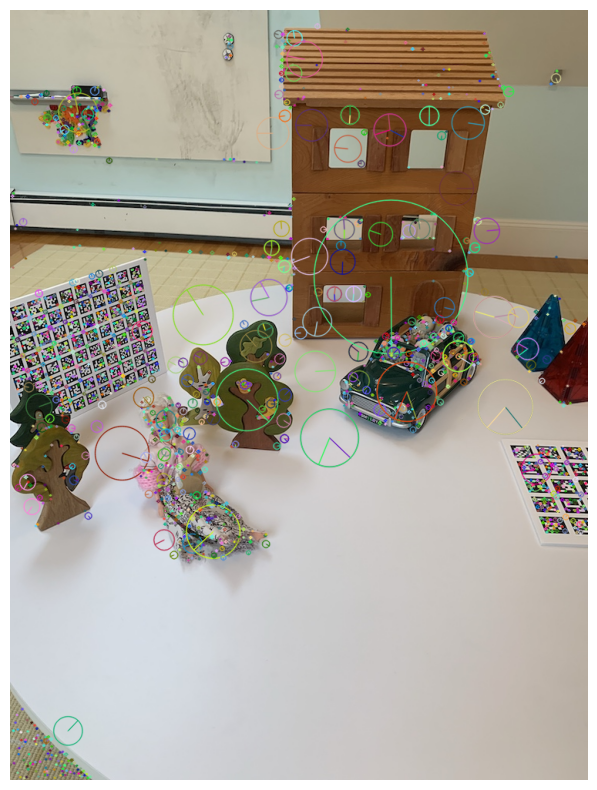

In [14]:
displayKeypoints(keypoints1, descriptors1, im1)

In [15]:
def matchKeypoints(keypoints1, keypoints2, descriptors1, descriptors2, percentage):
    """
    Find interest-point matches between two lists of interest point descriptors

    Args:
      keypoints1 - keypoints from sift.detectAndCompute() applied to Image 1
      keypoints2 - keypoints from sift.detectAndCompute() applied to Image 2
      descriptors1 - descriptors from sift.detectAndCompute() applied to Image 1
      descriptors2 - descriptors from sift.detectAndCompute() applied to Image 2
      percentage - number between 0 and 1

    Returns
      matches - list of Dmatch objects, which each have the following atrributes:
                DMatch.distance - Distance between descriptors. Lower is better.
                DMatch.trainIdx - Index of descriptor in "train" descriptors (descriptors1)
                DMatch.queryIdx - Index of descriptor in "query" descriptors (descriptors2)
                DMatch.imgIdx   - Index of the train image (useful when working with a large set of images; can be ignored here)
      X1 - Nx2 numpy array of points (x,y) from Image 1
      X1 - Nx2 numpy array of points (x,y) from Image 2
    """

    # Create a "brute force" matcher object using the L2 norm,
    #  and using "cross check" to only keep symmetric matches
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Use the match method of this matcher object to match
    #   descriptors between images
    matches12 = bf.match(descriptors1, descriptors2)
    num_matches12 = len(matches12)

    # TO DO: modify this line of code to find and return the
    #   (percentage * num_matches12) subset of matches that have
    #   the smallest distance between them

    goodmatches12 = sorted(matches12, key = lambda x:x.distance)[:int(percentage * num_matches12)]

    # for convenience, extract and return pixel coordinates of the good matches
    X1 = np.array([keypoints1[match.queryIdx].pt for match in matches12])
    X2 = np.array([keypoints2[match.trainIdx].pt for match in matches12])

    return goodmatches12, X1, X2

In [16]:
GOOD_MATCH_PERCENTAGE = 0.2
goodmatches, X1, X2 = matchKeypoints(keypoints1, keypoints2, descriptors1, descriptors2, GOOD_MATCH_PERCENTAGE)

In [17]:
def displayMatches(im1, keypoints1, im2, keypoints2, matches):
    # create an image that shows the matches
    im_matches = cv2.drawMatches(im1,
                                keypoints1,
                                im2,
                                keypoints2,
                                matches,
                                None)

    # display the image in figure
    fig,ax = plt.subplots(figsize=(20,15))
    ax.imshow(im_matches)
    ax.axis('off')
    plt.show()

In [18]:
displayMatches(im1, keypoints1, im2, keypoints2, goodmatches)

Output hidden; open in https://colab.research.google.com to view.

#Essential Matrix

In [41]:
E, mask = cv2.findEssentialMat(X1, X2, calMatrix, method=cv2.RANSAC)
R1, R2, t = cv2.decomposeEssentialMat(E)
E

array([[-0.00099275,  0.1750571 ,  0.04545742],
       [-0.18590977, -0.00480449, -0.68064526],
       [-0.05302436,  0.68308687, -0.00221342]])

In [20]:
E2, _ = cv2.findEssentialMat(np.int32(X1), np.int32(X2), calMatrix, method=cv2.RANSAC)
np.set_printoptions(suppress=True)
E2

array([[-0.00009519,  0.11345861,  0.01123145],
       [-0.14464464,  0.00121103, -0.69206732],
       [-0.01450533,  0.69778493,  0.00246171]])

#Epipolar Line Visualization

[OpenCV Epipolar Geometry](https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html)

In [21]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines '''
    r,c, _ = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)

    return img1,img2

In [22]:
img1 = cv2.imread('./data/playroom1.jpg')  # right image
img2 = cv2.imread('./data/playroom2.jpg')  # left image


## Using Essential Matrix

In [23]:
pts1 = np.int32(X1)
pts2 = np.int32(X2)

# inlier points only
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, E)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, E)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(img3)
plt.title('Left Image with Epipolar Lines')
plt.axis('off')

plt.subplot(122)
plt.imshow(img5)
plt.title('Right Image with Epipolar Lines')
plt.axis("off")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Using Fundamental Matrix

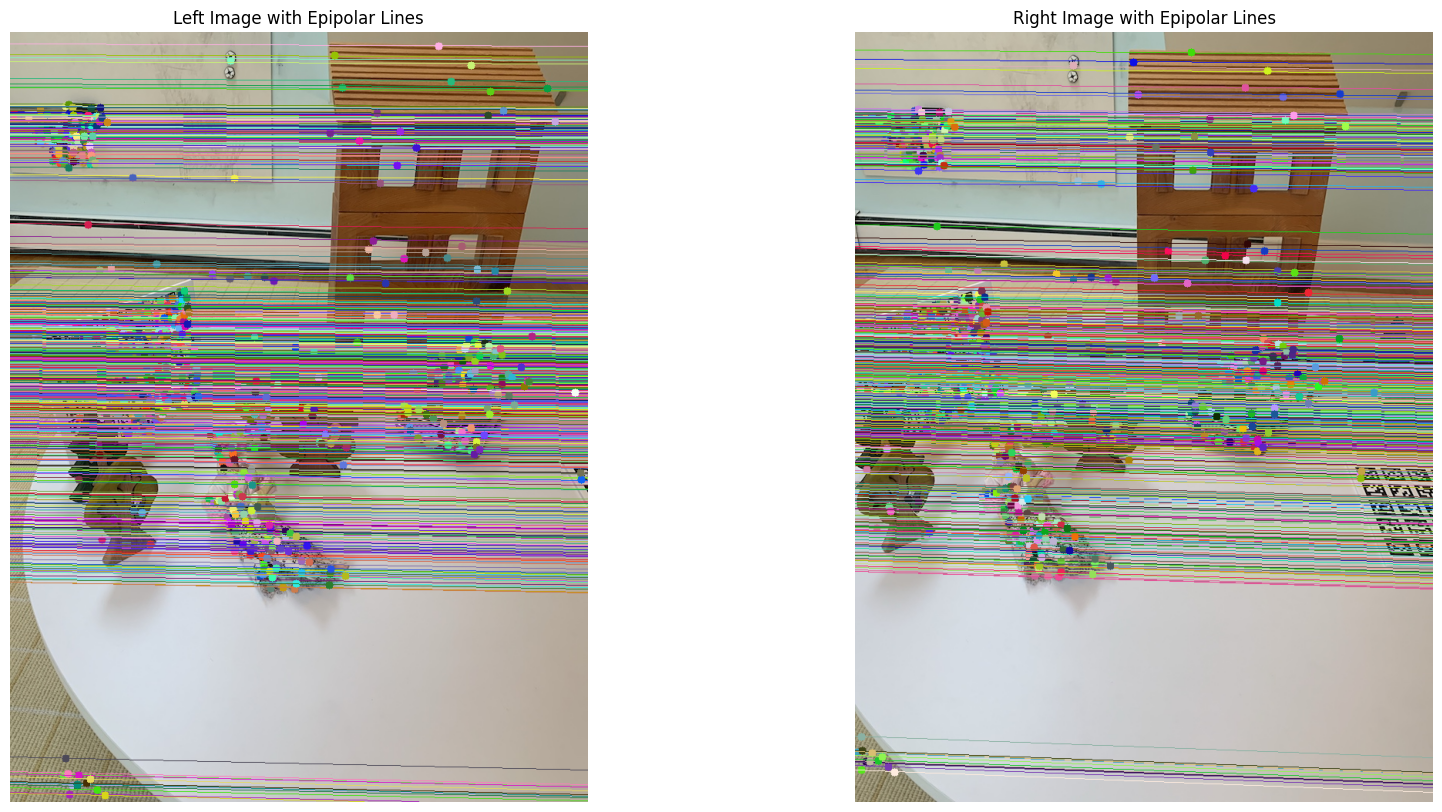

In [24]:
pts1 = np.int32(X1)
pts2 = np.int32(X2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(img3)
plt.title('Left Image with Epipolar Lines')
plt.axis('off')

plt.subplot(122)
plt.imshow(img5)
plt.title('Right Image with Epipolar Lines')
plt.axis("off")

plt.show()

## Using Fundamental Matrix and Calculating Points using FLANN matcher

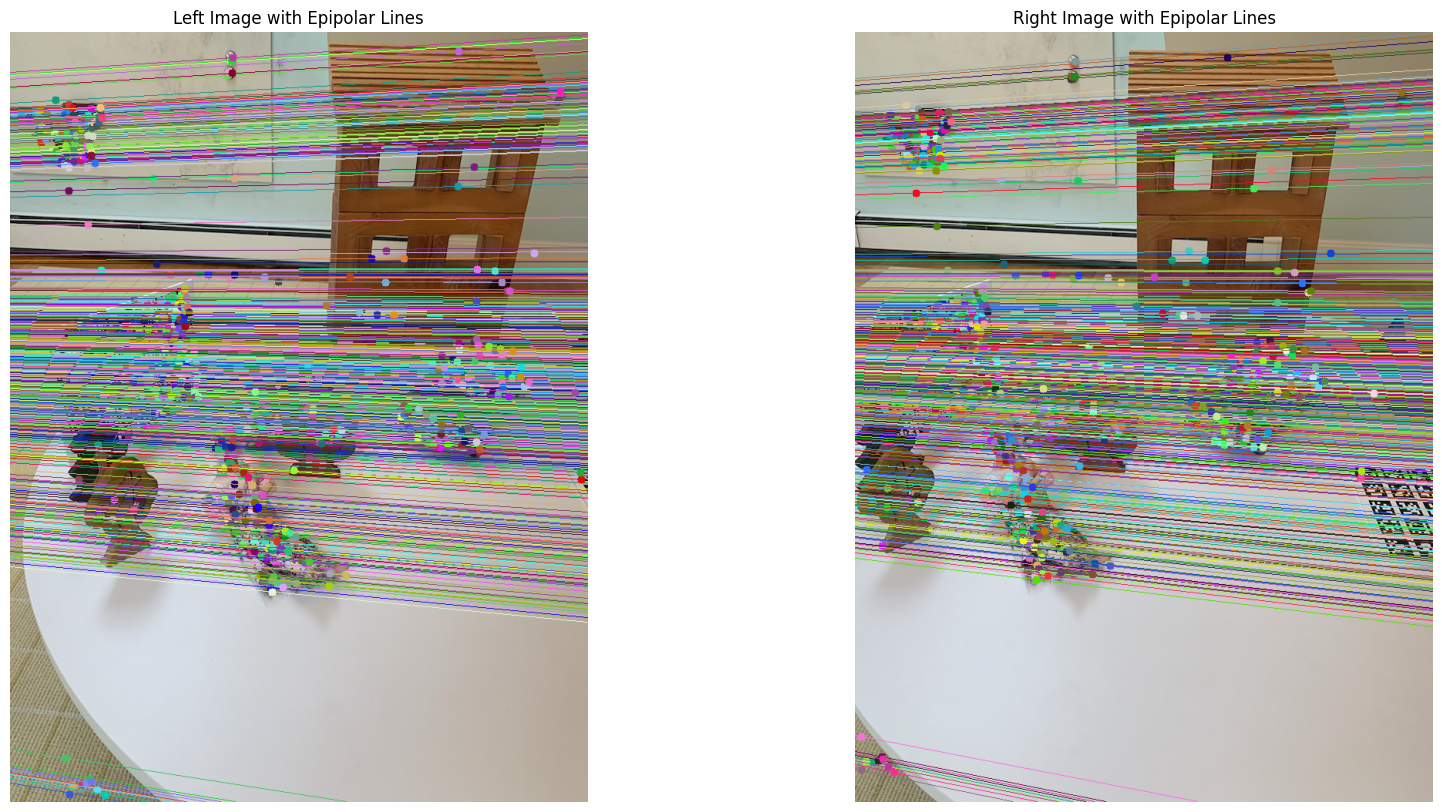

In [25]:
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
  if m.distance < 0.8*n.distance:
    pts2.append(kp2[m.trainIdx].pt)
    pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(img3)
plt.title('Left Image with Epipolar Lines')
plt.axis('off')

plt.subplot(122)
plt.imshow(img5)
plt.title('Right Image with Epipolar Lines')
plt.axis("off")

plt.show()

# Triangulation

In [42]:
Ps = []
# test1 = np.int32(X1)
# test1 = np.int32(X2)
test1 = X1[mask.ravel() == 1]
test2 = X2[mask.ravel() == 1]

# Calculate projection matrix P1 for the first camera (assuming identity rotation and zero translation)
P1 = np.dot(calMatrix, np.hstack((np.eye(3), np.zeros((3, 1)))))
Ps.append(P1)

# Calculate projection matrix P2 for the second camera
P2 = np.dot(calMatrix, np.hstack((-R2, t)))
Ps.append(P2)

# Triangulate 3D points from matched keypoints
# points_4d_homogeneous = cv2.triangulatePoints(P1, P2, X1.T, X2.T)
points_4d_homogeneous = cv2.triangulatePoints(P1, P2, test1.T, test2.T)

# Convert homogeneous coordinates to Cartesian coordinates
points_3d_cartesian = points_4d_homogeneous[:3, :] / points_4d_homogeneous[3, :]
# points_3d_cartesian = hom2in(points_4d_homogeneous)

# Transpose the points to get a list of 3D points
points = points_3d_cartesian.T

# Display the triangulated 3D points
print("Triangulated 3D points:")
print(points)

Triangulated 3D points:
[[-4.13785304 -0.26663369  7.99074203]
 [-4.15143531 -0.0621634   8.04221829]
 [-4.09622801 -0.30685444  7.93837752]
 ...
 [ 2.77464207  1.19861522  8.34870737]
 [ 2.83703012  1.12336198  8.49486181]
 [ 3.95089752  0.01428431 11.12437009]]


#3D Visualization

In [43]:
def add_plotly_camera(h,w,camera,raysize,figobj):
# Add tetrahedral camera to pyplot figure
# h,w:      height and width of image in pixels
# camera:   3x4 camera matrix
# raysize:  length of tetrahedral edges (in world units)
# fig:      pyplot figure object
#
# Returns: 1
#
# Uses anatomy of camera matrices from Hartley and Zisserman Chapter 6

    # normalize camera such that bottom-left three-vector
    #   corresponds to unit-length principal ray in front of camera (HZ Section 6.2.3)
    camera=camera*np.sign(np.linalg.det(camera[:,0:3]))/np.linalg.norm(camera[2,0:3])

    # Compute camera center (null vector of P)
    _, _, v = np.linalg.svd(camera)
    C = np.transpose(v[-1,0:3]) / v[-1,3]

    # Back-project image corners to unit-length 3D ray segments:
    S = np.array([[0, 0, 1],       # homog image coords if top left pixel
                  [0, h-1, 1],     # bottom left
                  [w-1, h-1, 1],   # bottom right
                  [w, 0, 1]])      # top right

    #   HZ equation (6.14): compute one 3D point along each ray
    X = np.transpose(np.linalg.lstsq(
        camera[:,0:3],
        np.transpose(S)-np.expand_dims(camera[:,3],axis=1),
        rcond=None)[0])

    #   unit-vectors from camera center to each 3D point
    V = X - np.tile(C, (4, 1))
    V = V / np.linalg.norm(V, ord=2, axis=1, keepdims=True)

    # make sure these vectors point forwards from the camera instead of backwards
    V = V*np.expand_dims(np.sign(np.sum(V * np.tile(camera[2,0:3],(4, 1)), axis=1)),axis=1)

    #   desired ray segments that are length raysize in these directions
    V = np.tile(C, (4, 1)) + raysize * V

    # append the camera center itself to complete the four tetrahedral vertices
    V=np.vstack([C,V])

    # add camera center to figure
    figobj.add_trace(go.Scatter3d(
        x=[C[0]],
        y=[C[1]],
        z=[C[2]],
        mode='markers',
        marker=dict(
            size=3,
            color='#ff7f0e'
        )
    )
                    )


    # add tetrahedron to figure
    figobj.add_trace(go.Mesh3d(
        # vertices of tetrahedron
        x=V[:,0],
        y=V[:,1],
        z=V[:,2],

        # i, j and k give the vertices of triangles
        i=[0, 0, 0, 0],
        j=[1, 2, 3, 4],
        k=[2, 3, 4, 1],
        opacity=0.5,
        color='#ff7f0e'
    ))

    return 1

In [44]:
def visualizeObjectPoints(points, Ps):
  h, w, _ = im1.shape

  # Create a new Plotly figure
  fig = go.Figure()

  # Add your triangulated 3D points to the figure
  fig.add_trace(go.Scatter3d(
      x=points[:, 0],
      y=points[:, 1],
      z=points[:, 2],
      mode='markers',
      marker=dict(
          size=2,
          color='#1f77b4')
  ))

  # Add the cameras to the figure
  for i in range(len(Ps)):
    add_plotly_camera(h, w, Ps[i], 1, fig)

  # Update the layout for better visualization
  fig.update_layout(
      scene=dict(
          aspectmode='cube',
          xaxis=dict(title='X'),
          yaxis=dict(title='Y'),
          zaxis=dict(title='Z')
      )
  )

  fig.update_layout(scene=dict(
        xaxis=dict(range=[-30, 30]),
        yaxis=dict(range=[-30, 30]),
        zaxis=dict(range=[-10, 100]))
    )

  # fig.update_layout(scene=dict(
  #       xaxis=dict(range=[-2, 2]),
  #       yaxis=dict(range=[-2, 2]),
  #       zaxis=dict(range=[-1, 3]))
  #   )

  # # adjust aspect ratio and initial viewing direction
  # fig.update_layout(scene_aspectmode='manual',
  #                   scene_aspectratio=dict(x=1, y=2, z=3),
  #                   showlegend=False,
  #                   scene_camera=dict(
  #                       up=dict(x=0, y=1, z=0),
  #                       center=dict(x=0, y=0, z=0),
  #                       eye=dict(x=-1, y=-1, z=-5)
  #                   )
  #                   )

  # Show the figure
  fig.show()


In [55]:
visualizeObjectPoints(points, Ps)

#PnP Solver

In [46]:
im3 = cv2.cvtColor(cv2.imread('./data/playroom3.jpg'), cv2.COLOR_BGR2RGB)

In [47]:
keypoints3, descriptors3 = detectKeypoints(im3)

In [48]:
GOOD_MATCH_PERCENTAGE = 0.2
goodmatches2, X1_X3, X3 = matchKeypoints(keypoints1, keypoints3, descriptors1, descriptors3, GOOD_MATCH_PERCENTAGE)

In [52]:
# Find the points that appear in matches between both X1 and X3 and X1 and X2
mask = np.array([1 if pt in X1 else 0 for pt in X1_X3])
mask = mask.ravel() == 1

X3_submatches = X3[mask==1]
X1_submatches = X1_X3[mask==1]

In [53]:
# Find the 3D correspondences for all the points that appear in matches between both X1 and X3 and X1 and X2
matching_points3d = []

for point in X1_submatches:
  for pt3, twoD in zip(points, X1):
    if twoD[0] == point[0] and twoD[1] == point[1]:
      matching_points3d.append(pt3)
      break

matching_points3d = np.array(matching_points3d)

In [54]:
[_, rvec, tvec, inliers] = cv2.solvePnPRansac(matching_points3d, X3_submatches, calMatrix, None)
R_13, _ = cv2.Rodrigues(rvec)

P3 = calMatrix @ np.hstack((R_13, tvec))
Ps.append(P3)

error: OpenCV(4.8.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'


In [36]:
new_point_cloud = cv2.triangulatePoints(P1, P3, X1_submatches.T, X3_submatches.T)
new_points = hom2in(new_point_cloud.T)
final = np.concatenate([new_points, points], axis=0)

In [37]:
visualizeObjectPoints(final, Ps)